# MCMC Modeling of Eclipses / Transits

- Focused on using MCMC to identify period and t0, rather than complete modeling

In [11]:
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

import emcee

import corner


%matplotlib inline

In [12]:
# emcee parallel helper

import os
import multiprocessing
from multiprocessing import Pool
import psutil

class EmceePoolContext:
    """A Context Manager to manage `Pool` instances with `emcee` specific tweaks."""

    def __init__(self, pool: multiprocessing.pool.Pool, auto_close: bool):
        self.pool = pool
        self.auto_close = auto_close
        self._existing_omp_num_threads = None

    def __enter__(self):
        if self.pool is not None:
            # case parallel emcee is enabled,
            # turn off numpy parallel operations to avoid possible conflicts:
            # see: https://emcee.readthedocs.io/en/stable/tutorials/parallel/#parallel
            self._existing_omp_num_threads = os.environ.get("OMP_NUM_THREADS", None)
            os.environ["OMP_NUM_THREADS"] = "1"

    def __exit__(self, exc_type, exc_value, exc_traceback):
        if self.pool is not None:
            if self._existing_omp_num_threads is None:
                del os.environ["OMP_NUM_THREADS"]
            else:
                os.environ["OMP_NUM_THREADS"] = self._existing_omp_num_threads

        if self.pool is not None and self.auto_close:
            self.pool.close()


def _parse_pool_param(pool):
    """
    Parse the `pool` parameter shared by various mcmc functions.
    It allows caller to pass a `Pool` instance or various shorthands
    """
    def cpu_count():
        # Return number of actual physical CPUs,
        # discounting logical ones due to, e.g., hyper-threading.
        #
        # The MCMC work below to be parallelized is CPU intensive,
        # such that the apparent advantage from hyper-threading is
        # next to nothing (and possibly worse).
        # So number of physical CPUs is used as the basis.
        return psutil.cpu_count(logical=False)

    if pool is None:
        return None, False  # <-- is pool_from_caller

    if isinstance(pool, multiprocessing.pool.Pool):
        # multiprocessing.pool.Pool is the class, while
        # multiprocessing.Pool is a factory function to create the instances
        is_pool_from_caller = True
    else:
        is_pool_from_caller = False
        if pool == "all":
            num_processes_to_use = cpu_count()
            print(f"[INFO] emcee parallel enabled, use all {num_processes_to_use} CPUs.")
            pool = Pool(num_processes_to_use)
        elif isinstance(pool, int):
            if pool > 0:
                num_processes_to_use = pool
            else:
                # use all but {pool} CPUs
                num_processes_to_use = cpu_count() - (-pool)
            print(f"[INFO] emcee parallel enabled, use {num_processes_to_use} CPUs.")
            pool = Pool(num_processes_to_use)
        else:
            raise TypeError(
                '`pool` must be None, "all", '
                "int (for num processes, negative to use all but the specified num. of CPUs), "
                "or a `Pool` instance."
            )
        return pool, is_pool_from_caller


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 14,2019,SPOC,120,352165018,0.0,G022062
1,TESS Sector 15,2019,SPOC,120,352165018,0.0,G022062
2,TESS Sector 16,2019,SPOC,120,352165018,0.0,G022062
3,TESS Sector 41,2021,SPOC,120,352165018,0.0,"G04171 , G04234"
4,TESS Sector 55,2022,SPOC,120,352165018,0.0,"G04171 , G04234"
5,TESS Sector 56,2022,SPOC,120,352165018,0.0,G05003
6,TESS Sector 75,2024,SPOC,120,352165018,0.0,G06057
7,TESS Sector 76,2024,SPOC,120,352165018,0.0,G06057
8,TESS Sector 82,2024,SPOC,120,352165018,0.0,G06057


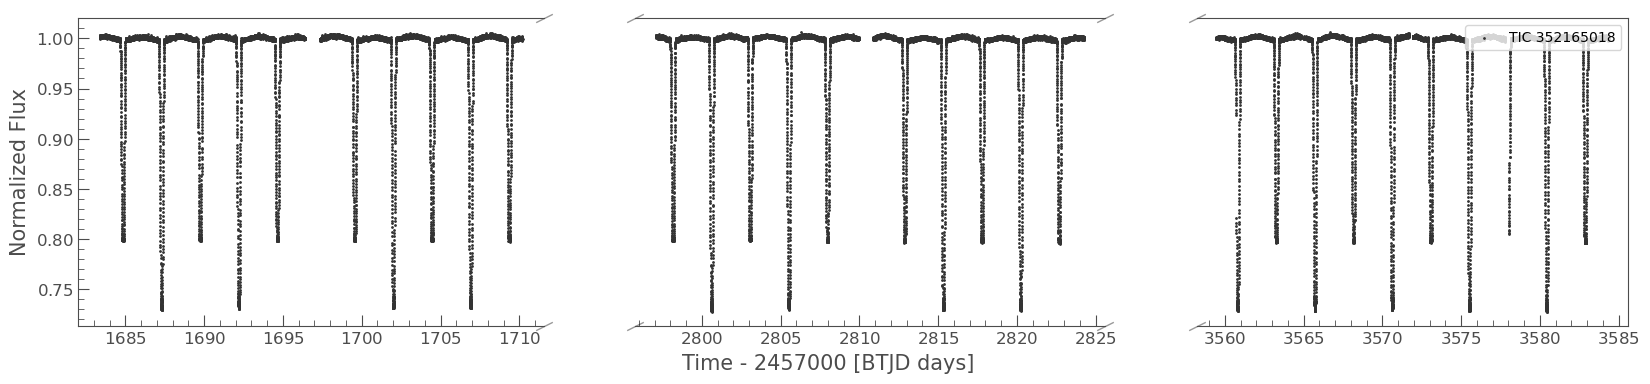

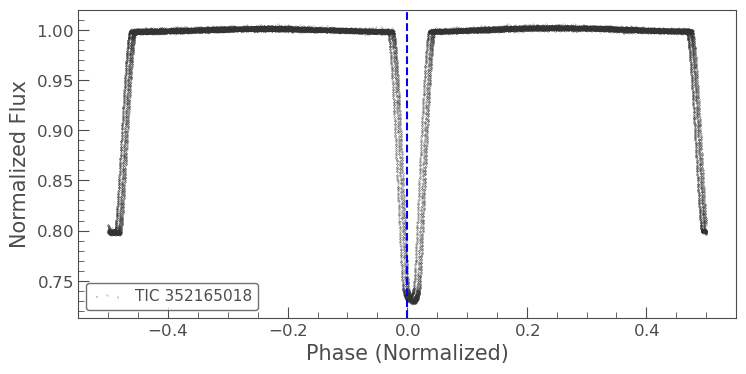

In [13]:
import tic_plot as tplt
import lightkurve_ext as lke

tic = 352165018  # an EA https://vsx.aavso.org/index.php?view=detail.top&oid=172719
sr = lk.search_lightcurve(f"TIC{tic}", mission="TESS", author="SPOC", cadence="short")
display(sr)

# use only a subset of data to speed things up
lcc = lke.of_sectors(sr, 14, 55, 83).download_all()
lc = lcc.stitch().normalize()

axs = tplt.plot_skip_data_gap(lc, figsize=(20, 4));

period_initial = 4.9044
t0_initial = 1687.28

lc_f = lc.fold(period=period_initial, epoch_time=t0_initial, normalize_phase=True)
ax = lc_f.scatter(s=0.1);
ax.axvline(0, c="blue", linestyle="--", label="EB1");

### Clipped data for MCMC

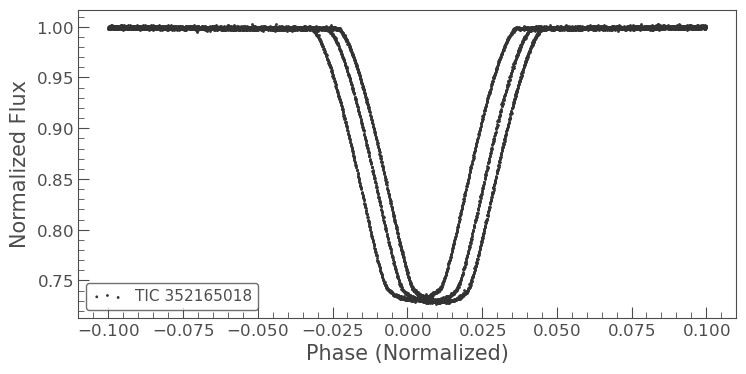

In [14]:
lc_f_trunc = lc_f.truncate(-0.1, 0.1);
lc_f_trunc.scatter();

data = SimpleNamespace(
    time=lc_f_trunc.time_original.value, # we need the original time, rather than phase
    flux=lc_f_trunc.flux.filled(np.nan).value,
    err=lc_f_trunc.flux_err.filled(np.nan).value,
)


## Geometric model `cosh` Gaussian

- the model function must be top level functions. 
- In particular, the log likelihood function passed to `emcee`, `cosh_log_posterior()` in this case, must be a top level function (emcee restriction)

In [15]:
def phase_data(time, t0, period):
    """
    Calualate the phase given a t0 and period.
    """
    return np.array([-0.5 + ((t - t0 - 0.5 * period) % period) / period for t in time])


def coshg_log_prior(theta):
    alpha0, alpha1, t0, d, Tau, p = theta

    # no t0 check, as t0 is time, not phase
    if (0 < alpha0 < 10) and (-10 < alpha1 < 0) and (0 < d < 10) and (0.5 < Tau < 50):
        return 0.0
    return -np.inf


def coshg_log_likelihood(theta, x, y, yerr):

    alpha0, alpha1, t0, d, Tau, p = theta

    x_phase = phase_data(x, t0, p)
    t0_phase = phase_data([t0], t0, p)[0]
    cosh_term = np.cosh((x_phase - t0_phase) / d)
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), Tau)

    psi = 1 - pow_term

    model = alpha0 + (alpha1 * psi)

    return -0.5 * np.sum((y - model) ** 2 / (yerr**2))


def coshg_log_posterior(theta, x, y, yerr):

    # check that the priors are satisfied
    lp = coshg_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + coshg_log_likelihood(theta, x, y, yerr)


def coshgauss_model(x, alpha0, alpha1, t0, d, Tau, p):
    """
    Calculates the coshgauss model fit for the given parameters.

    Parameters:
    x (float): The input value (time, NOT phase)
    alpha0 (float): The coefficient for the constant term.
    alpha1 (float): The coefficient for the psi term.
    t0 (float): The center of the cosh term. (time, NOT phase)
    d (float): The width of the cosh term.
    Tau (float): The exponent for the pow term.
    p (float): the period

    Returns:
    float: The model fit value.
    """
    x_phase = phase_data(x, t0, p)
    t0_phase = phase_data([t0], t0, p)[0]
    cosh_term = np.cosh((x_phase - t0_phase) / d)
    exp_term = np.exp(1 - cosh_term)
    pow_term = pow((1 - exp_term), Tau)

    psi = 1 - pow_term

    model = alpha0 + (alpha1 * psi)

    return model



### Initial Model Parameters Guess

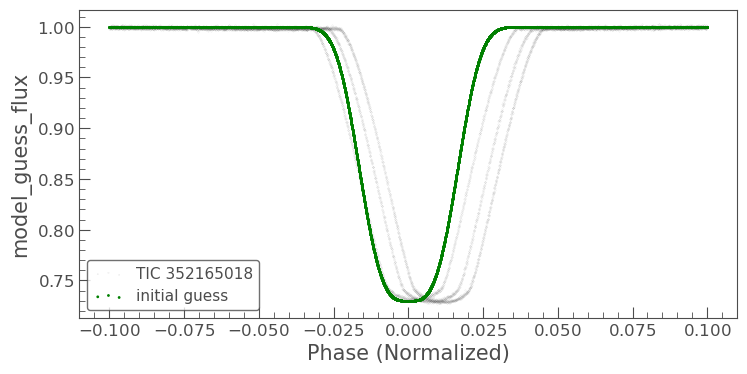

In [16]:
start_vals = [1, -0.27, t0_initial, 0.012, 1.8, period_initial]

lc_f_trunc["model_guess_flux"] = coshgauss_model(lc_f_trunc.time_original.value, *start_vals)
ax = lc_f_trunc.scatter(alpha=0.2, s=0.1);
lc_f_trunc.scatter(column="model_guess_flux", ax=ax, c="green", label="initial guess");


### Run MCMC

In [17]:
nruns = 1000
nwalkers = 128

emcee_pool_size = None  # set to None to disable parallel emcee. Somehow parallel does not work

def get_starting_positions(start_vals, scale=1e-5, nwalkers=128):
    p0 = np.array([[val + scale * np.random.randn() for jj, val in enumerate(start_vals)] for i in range(nwalkers)])
    yield p0


pool, _ = _parse_pool_param(emcee_pool_size)
with EmceePoolContext(pool, auto_close=True):

    # start in the vicinity of the start_vals
    pos = list(get_starting_positions(start_vals, nwalkers=nwalkers))[0]
    print(pos.shape)

    ndim = len(start_vals)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, coshg_log_posterior, args=(data.time, data.flux, data.err), pool=pool)
    print(sampler)

    sampler.run_mcmc(pos, nruns, progress=True, store=True)


(128, 6)


100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


### Check Convergence

ensemble chains shape: (1000, 128, 6)


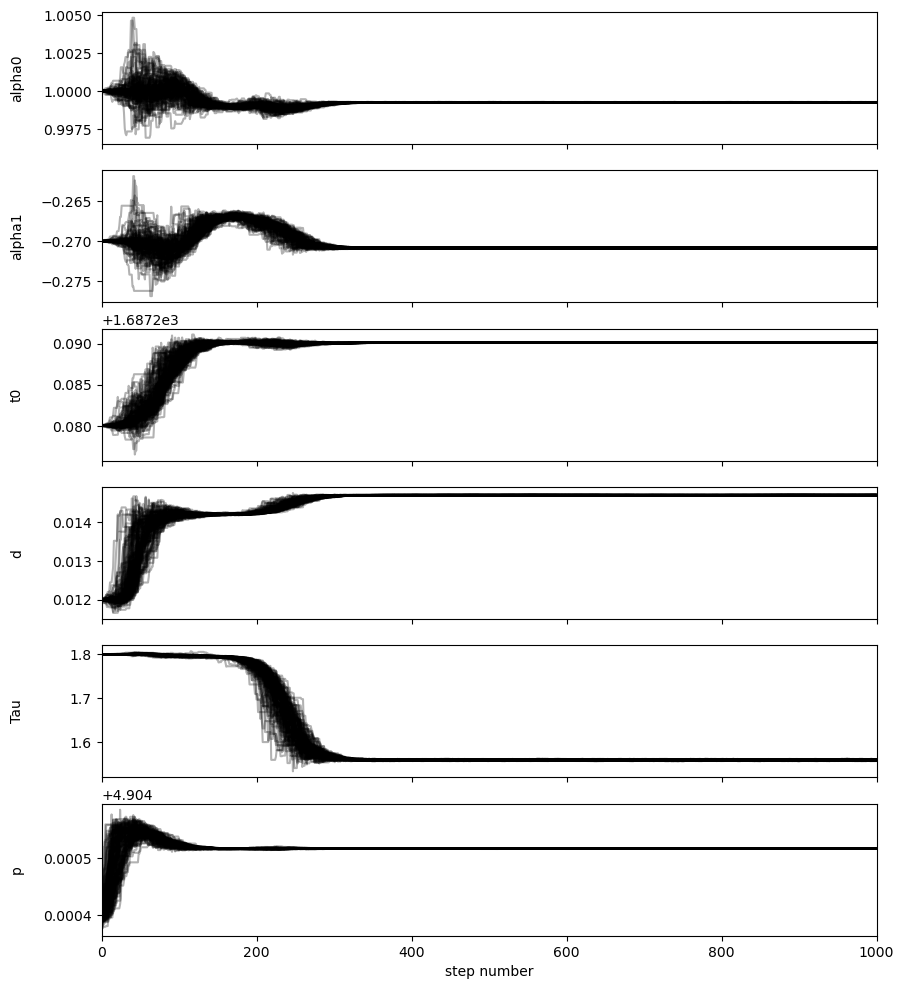

In [18]:
coshg_labels = ["alpha0", "alpha1", "t0", "d", "Tau", "p"]

def plot_chains(samples, labels):
    nparams = len(labels)
    fig, axes = plt.subplots(nparams, figsize=(10, 2 * nparams), sharex=True)

    print("ensemble chains shape:", samples.shape)
    for i in range(nparams):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    return fig, axes


fig, axes = plot_chains(sampler.get_chain(), coshg_labels);

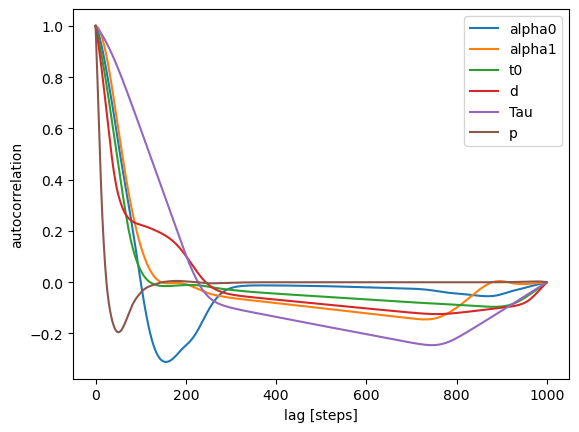

In [19]:
def acorfn(x):
    n = len(x)
    f = np.fft.rfft(x - np.mean(x), n=2*n)
    acf = np.fft.irfft(f * np.conjugate(f))[:n].real
    return acf / acf[0]


def get_mean_samples(samples):
    nruns, nwalker, nparams = samples.shape
    return np.array([
        [ np.mean(samples[i, :, j]) for j in range(nparams) ]
        for i in range(nruns)
    ])


def plot_autocorrelation(samples, labels):
    mean_samples = get_mean_samples(samples)  # the ensemble samples

    ax = plt.figure().gca()
    for i, label in enumerate(labels):
        ax.plot(emcee.autocorr.function_1d(mean_samples[:, i]), label=label)
        # ax.plot(acorfn(mean_samples[:, i]), label=label)
    ax.set_xlabel("lag [steps]")
    ax.set_ylabel("autocorrelation")
    ax.legend()

    return ax


ax = plot_autocorrelation(sampler.get_chain(), coshg_labels)

In [20]:
# tol=0 so that it does not raise error (that the chain is too short)
tau = sampler.get_autocorr_time(tol=0)
print(tau)
print(max(tau))

[ 41.9365377   86.71689772  81.30727762  98.70152802 124.57337249
  13.25859553]
124.57337249239146


### Filter the samples to calculate teh result

- flatten, discard those from the beginning, thinning

In [21]:
# `flat_samples_chosen` is analogous to `line_chains_chosen`
# - discard is few times over max(tau)
# - thin is about half the autocorrelation time
flat_samples_chosen = sampler.get_chain(discard=500, thin=60, flat=True)
print(flat_samples_chosen.shape)

(1024, 6)


### Model Result Visualization and Summary Statistics

In [22]:
def create_posterior_summary(samples, labels):
    samples_dict = { l: samples[:, i] for i, l in enumerate(labels) }

    stats_dict = {}
    for param_name, chain in samples_dict.items():
        stats_dict[param_name] = dict(
            mean=np.nanmean(chain),
            std=np.nanstd(chain),
            pct16=np.percentile(chain, 16),
            pct84=np.percentile(chain, 84),
            num_iter=len(chain),
        )
    return stats_dict




def to_stats_table(stats_dict):
    def dict_of_row(key, a_dict):
        res = dict(parameter=key)
        res.update(a_dict)
        return res

    from astropy.table import Table
    return Table(rows=[dict_of_row(k, v) for k, v in stats_dict.items()])


stats_dict = create_posterior_summary(flat_samples_chosen, coshg_labels)
to_stats_table(stats_dict)

parameter,mean,std,pct16,pct84,num_iter
str6,float64,float64,float64,float64,int32
alpha0,0.9992558281217375,8.988216440481397e-06,0.9992470963741379,0.9992646086875167,1024
alpha1,-0.27086095761544315,2.6607686929061716e-05,-0.2708861940230366,-0.270836294747851,1024
t0,1687.2901155174677,1.0798913652208732e-05,1687.2901048813496,1687.2901260867252,1024
d,0.014687539794966578,2.3572006983232763e-06,0.014685242733937563,0.0146898349789687,1024
Tau,1.5585106178149584,0.000862749216732169,1.5576397007978031,1.5593705429612061,1024
p,4.904515437841534,3.960698565533975e-08,4.904515398961399,4.90451547734396,1024


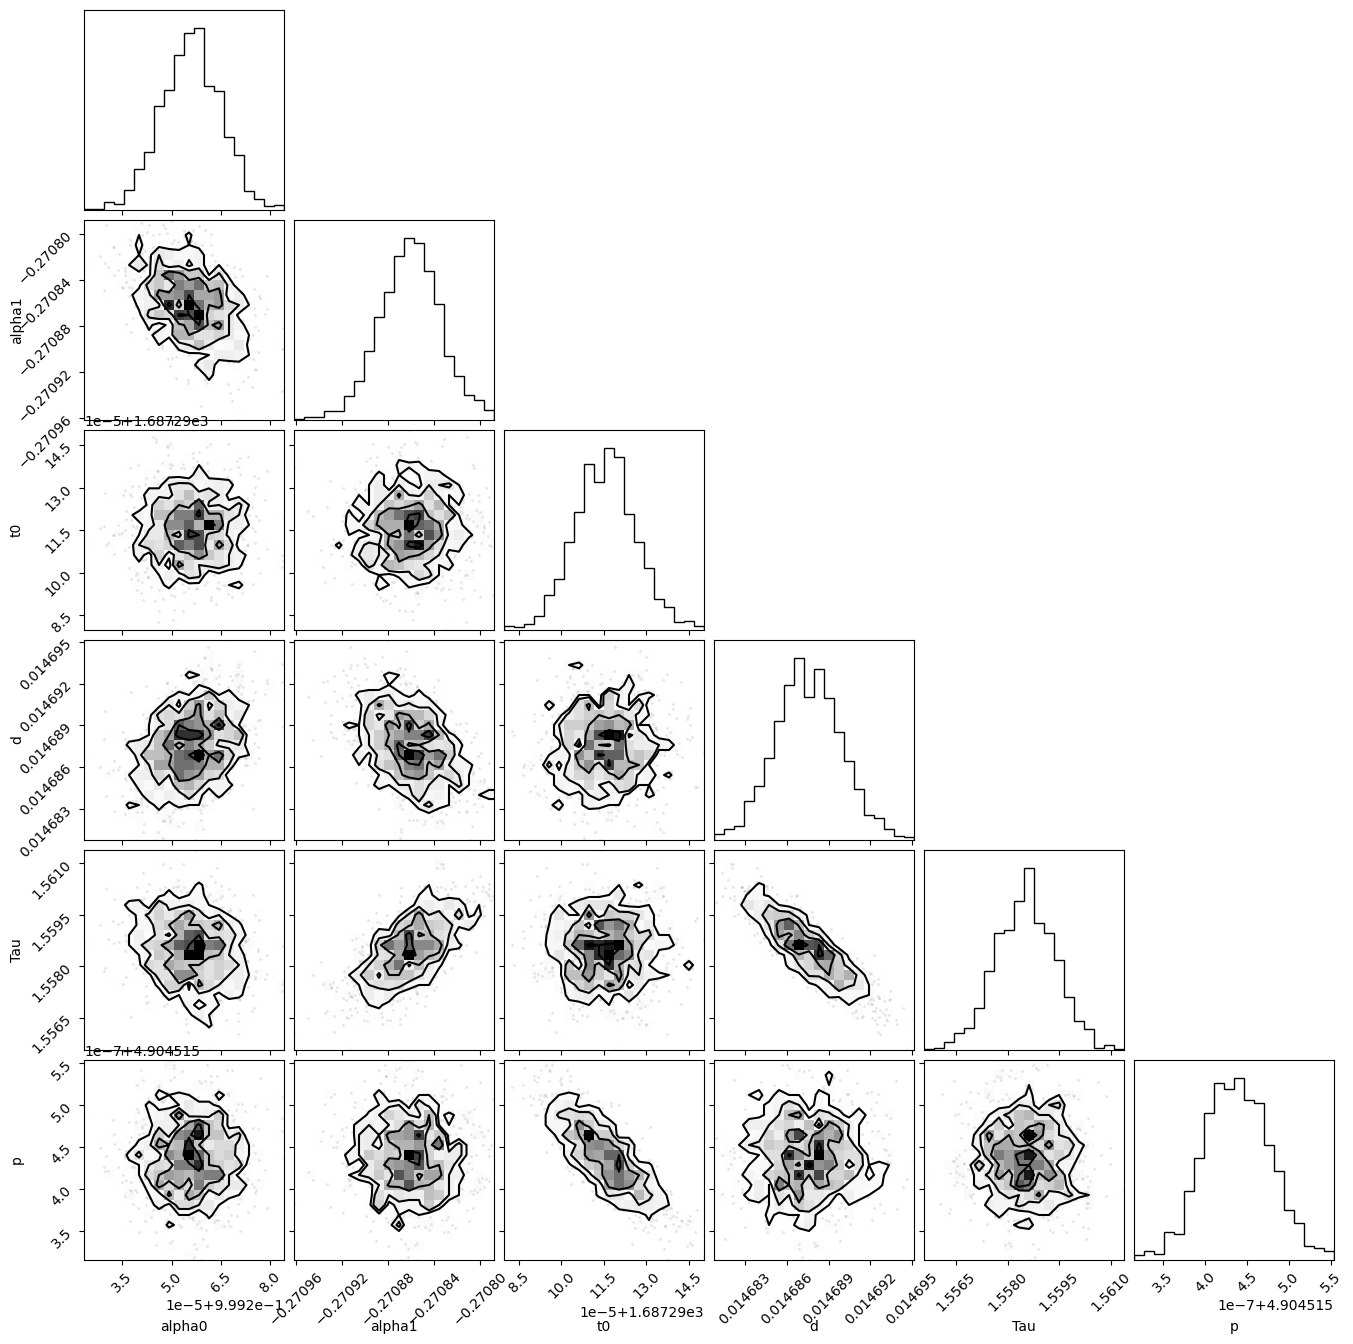

In [23]:
fig = corner.corner(flat_samples_chosen, labels=coshg_labels);

fitted results
period= 4.904515399082386 epoch_time= 1687.2901197805952


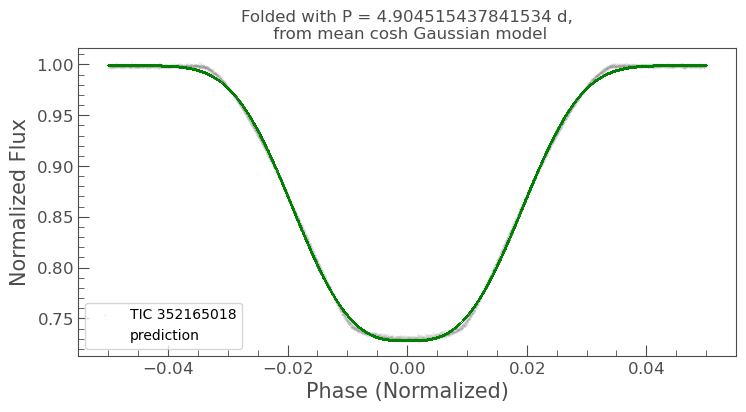

In [26]:
s_stats = create_posterior_summary(flat_samples_chosen, coshg_labels)
theta = [d["mean"] for d in s_stats.values()]

lc_f_prediction = lc.fold(period=theta[5], epoch_time=theta[2], normalize_phase=True).truncate(-0.05, 0.05)
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d,\n from mean cosh Gaussian model");


time = lc_f_prediction.time_original.value

for i, idx in enumerate(np.random.randint(len(flat_samples_chosen), size=100)):
    theta = flat_samples_chosen[idx]
    label = "prediction" if i == 0 else None
    y = coshgauss_model(time, *theta)
    ax.scatter(lc_f_prediction.time.value, y, c="green", alpha=0.05, s=0.01, label=label)

# y = coshgauss_model(time, *theta)
# ax.scatter(lc_f_prediction.time.value, y, c="red", alpha=1, s=1, label="prediction mean");

ax.legend();

print("fitted results")
print("period=", theta[5], "epoch_time=", theta[2])

## Geometric model Generalized Gaussian

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gennorm.html


### Generalized Gaussian illustration

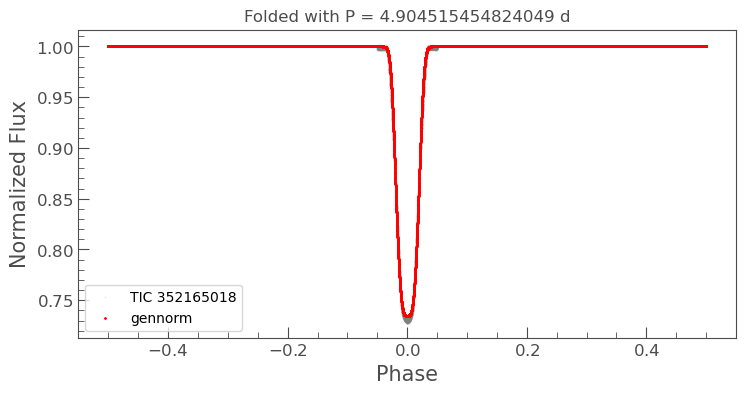

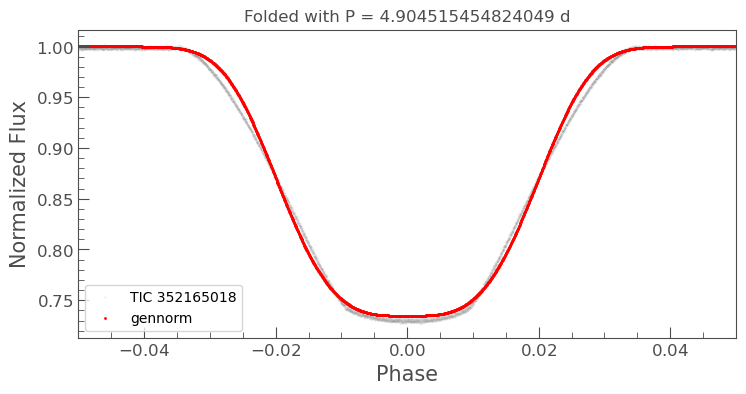

In [65]:
from scipy.stats import gennorm

# primarily affect
# shape, eclipse duration, amplitude
beta, scale, amp = 3.5, 0.022, -0.0105
# Tau,  d,   alpha1
# ^^^ coshgauss counterparts (roughly)
#
# param issues:
# - not orthogonal: there is some inter-dependency (degeneracy)
#   - e.g., changing scale not only affects duration, but also affects amplitude
# - they don't map to what's observed

x = np.linspace(-0.5, 0.5, num=20000)
y = 1 + amp * gennorm.pdf(x, beta, scale=scale)

# this is the data folded by the coshgauss model above
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d");

# overlay it with the model here
ax.scatter(x, y, label="gennorm", c="red", alpha=1, s=1);
ax.legend();


# a zoom-in-plot
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d");

# overlay it with the model here
ax.scatter(x, y, label="gennorm", c="red", alpha=1, s=1);
ax.legend();
ax.set_xlim(-0.05, 0.05);



### Actual Generalized Gaussian Model

In [78]:
from scipy.stats import gennorm


def gennorm_log_prior(theta):
    alpha0, alpha1, t0, scale, beta, p = theta

    # largely no prior fow now
    if (0 < alpha0 < 10):
        # in coshg_ version
        # (0 < alpha0 < 10) and (-10 < alpha1 < 0) and (0 < d < 10) and (0.5 < Tau < 50)
        return 0.0
    return -np.inf


def gennorm_log_likelihood(theta, x, y, yerr):

    alpha0, alpha1, t0, scale, beta, p = theta

    x_phase = phase_data(x, t0, p)
    model = alpha0 + alpha1 * gennorm.pdf(x_phase, beta, scale=scale)

    return -0.5 * np.sum((y - model) ** 2 / (yerr**2))


def gennorm_log_posterior(theta, x, y, yerr):

    # check that the priors are satisfied
    lp = gennorm_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + gennorm_log_likelihood(theta, x, y, yerr)


def genonorm_model(x, alpha0, alpha1, t0, scale, beta, p):
    """
    Calculates the generalized Gaussian model fit for the given parameters.

    Parameters:
    x (float): The input value (time, NOT phase)
    alpha0 (float): The coefficient for the constant term.
    alpha1 (float):
    t0 (float): time of minimum / maximum at center(time, NOT phase)
    scale (float):
    beta (float):
    p (float): the period

    Returns:
    float: The model fit value.
    """
    x_phase = phase_data(x, t0, p)
    # t0_phase = phase_data([t0], t0, p)[0]
    # print("DBG t0_phase=", t0_phase)

    model = alpha0 + alpha1 * gennorm.pdf(x_phase, beta, scale=scale)

    return model




### Initial Model Parameters Guess

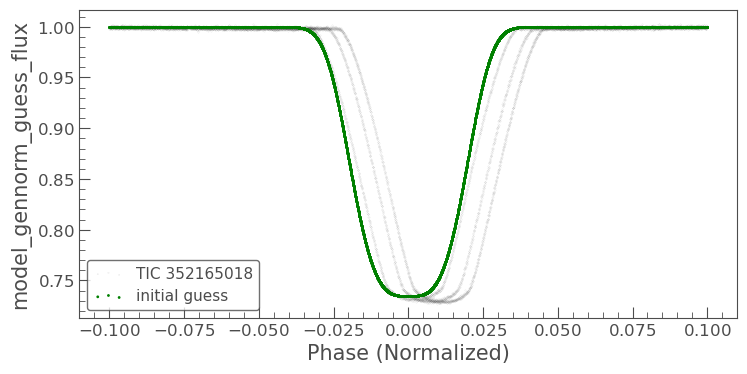

In [81]:
# alpha0, alpha1, t0, scale, beta, period
start_vals = [1, -0.0105, t0_initial, 0.022, 3.5, period_initial]


lc_f_trunc["model_gennorm_guess_flux"] = genonorm_model(lc_f_trunc.time_original.value, *start_vals)
ax = lc_f_trunc.scatter(alpha=0.2, s=0.1);
lc_f_trunc.scatter(column="model_gennorm_guess_flux", ax=ax, c="green", label="initial guess");


### Run MCMC

In [77]:
nruns = 1000
nwalkers = 128

emcee_pool_size = None  # set to None to disable parallel emcee. Somehow parallel does not work

def get_starting_positions(start_vals, scale=1e-5, nwalkers=128):
    p0 = np.array([[val + scale * np.random.randn() for jj, val in enumerate(start_vals)] for i in range(nwalkers)])
    yield p0


pool, _ = _parse_pool_param(emcee_pool_size)
with EmceePoolContext(pool, auto_close=True):

    # start in the vicinity of the start_vals
    pos = list(get_starting_positions(start_vals, nwalkers=nwalkers))[0]
    print(pos.shape)

    ndim = len(start_vals)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, gennorm_log_posterior, args=(data.time, data.flux, data.err), pool=pool)
    print(sampler)

    sampler.run_mcmc(pos, nruns, progress=True, store=True)


(128, 6)


100%|██████████| 1000/1000 [11:27<00:00,  1.46it/s]


### Check Convergence

ensemble chains shape: (1000, 128, 6)


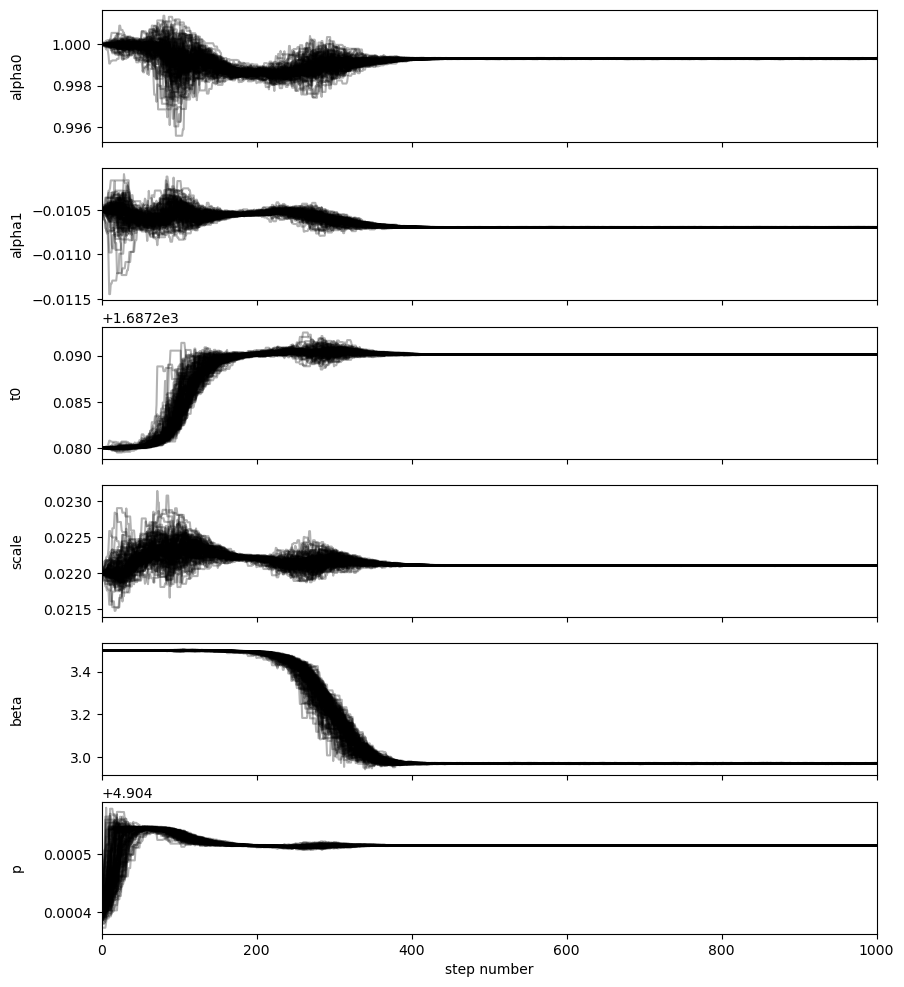

In [ ]:
gennorm_labels = ["alpha0", "alpha1", "t0", "scale", "beta", "p"]

fig, axes = plot_chains(sampler.get_chain(), gennorm_labels);

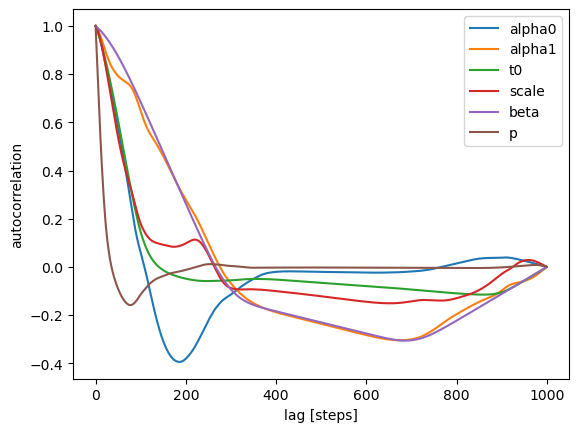

In [ ]:
ax = plot_autocorrelation(sampler.get_chain(), gennorm_labels);

In [80]:
tau = sampler.get_autocorr_time(tol=0)
print(tau)
print(max(tau))


[ 42.06330348 120.20422271  90.42144502  81.11160518 129.04759599
  19.32990403]
129.04759598564124


### Filter the samples to calculate the result

In [81]:
# - discard is few times over max(tau)
# - thin is about half the autocorrelation time
flat_samples_chosen = sampler.get_chain(discard=500, thin=60, flat=True)
print(flat_samples_chosen.shape)


(1024, 6)


### Model Result Visualization and Summary Statistics

In [82]:
stats_dict = create_posterior_summary(flat_samples_chosen, gennorm_labels)
to_stats_table(stats_dict)

parameter,mean,std,pct16,pct84,num_iter
str6,float64,float64,float64,float64,int32
alpha0,0.9993101601631383,9.130399241758157e-06,0.9993007262144428,0.9993191797744998,1024
alpha1,-0.010691842832440207,1.0367819183075886e-06,-0.010692905085363708,-0.010690777251719682,1024
t0,1687.29011368725,1.0975797831394269e-05,1687.2901027282333,1687.2901243444956,1024
scale,0.02210456426007964,1.7992115141288982e-06,0.022102718525798364,0.02210644354078368,1024
beta,2.970971619814038,0.00093155978899785,2.9700269719043413,2.971907831459666,1024
p,4.904515444530576,3.978387081491489e-08,4.9045154036842,4.90451548374234,1024


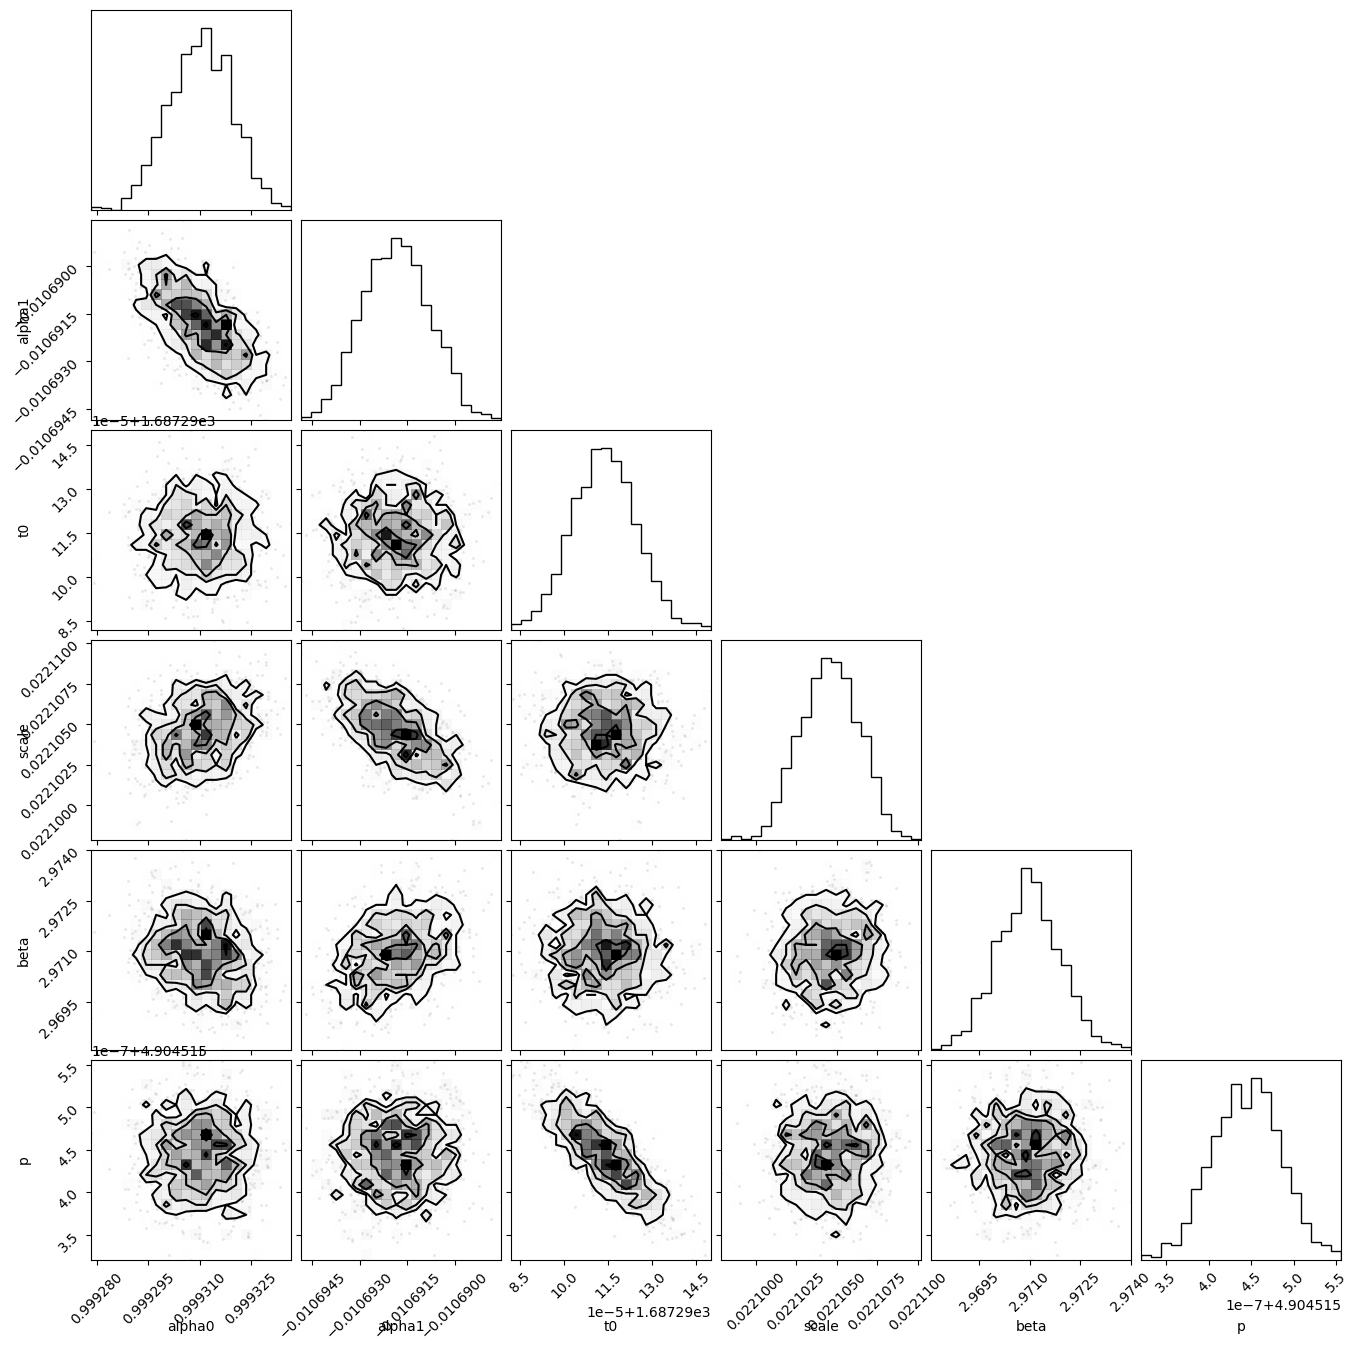

In [83]:
fig = corner.corner(flat_samples_chosen, labels=gennorm_labels);

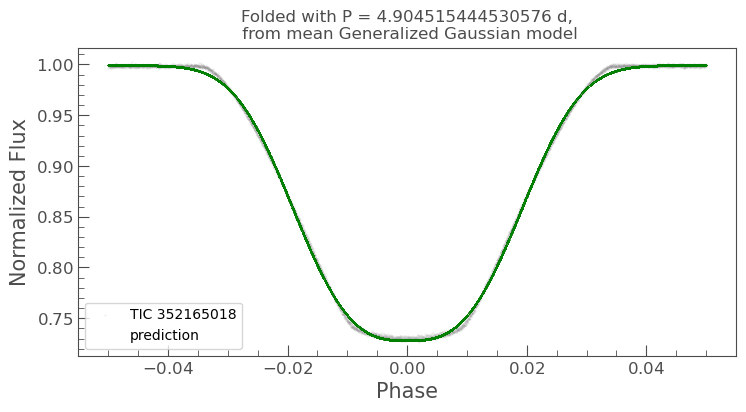

In [87]:
theta = [d["mean"] for d in stats_dict.values()]

lc_f_prediction = lc.fold(period=theta[5], epoch_time=theta[2], normalize_phase=True).truncate(-0.05, 0.05)
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d,\n from mean Generalized Gaussian model");


time = lc_f_prediction.time_original.value

for i, idx in enumerate(np.random.randint(len(flat_samples_chosen), size=100)):
    theta = flat_samples_chosen[idx]
    label = "prediction" if i == 0 else None
    y = genonorm_model(time, *theta)
    ax.scatter(lc_f_prediction.time.value, y, c="green", alpha=0.05, s=0.01, label=label)

# y = genonorm_model(time, *theta)
# ax.scatter(lc_f_prediction.time.value, y, c="red", alpha=1, s=1, label="prediction mean");

ax.legend();


## Generalized Gaussian Model 2

- based on [Kostov+ 2022, 97 Eclipsing 2+2 EBs](https://iopscience.iop.org/article/10.3847/1538-4365/ac5458#apjsac5458s4) equation (1)


### Illustration

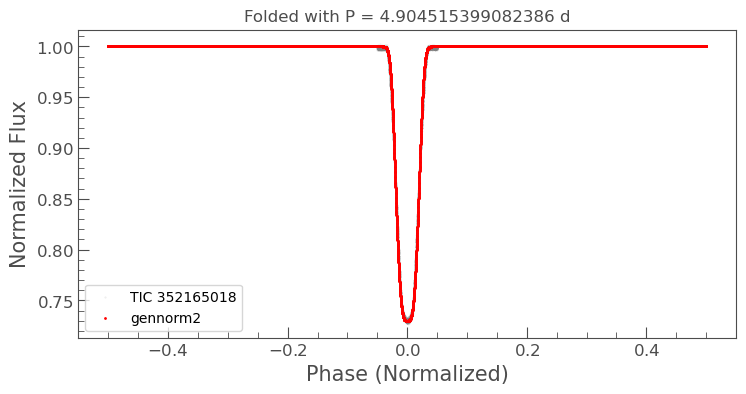

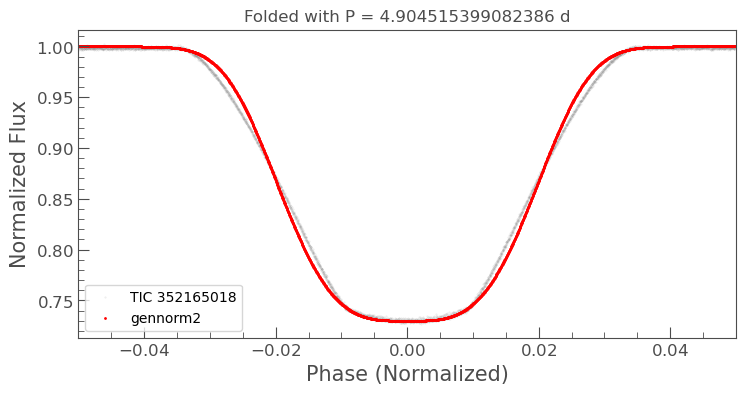

In [60]:
def gennorm2_model(x, A, B, t0, omega, beta, C, p):
    """
    Calculates the generalized Gaussian model fit for the given parameters.

    Parameters:
    x (float): The input value (time, NOT phase)
    A  (float): The coefficient for the constant term.
    B (float):
    t0 (float): time of minimum / maximum at center(time, NOT phase)
    omega (float):
    beta (float):
    C (float): to account for linear residual
    p (float): the period

    Returns:
    float: The model fit value.
    """
    x_phase = phase_data(x, t0, p)
    t0_phase = phase_data([t0], t0, p)[0]
    model = A - B * np.exp(-pow((np.abs(x_phase - t0_phase)/omega), beta)) + C * (x_phase - t0_phase)

    return model



# A, B, t0, omega, beta, C, period
# - we use period = 1, t0=0 to make the it like a phased plot,
# - C = 0
start_vals = [1, 0.27, 0, 0.022, 3.5, 0, 1]
y = gennorm2_model(x, *start_vals)

# # this is the data folded by the coshgauss model above
# ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
# ax.set_title(f"Folded with P = {theta[5]} d");

# this is the data folded by the coshgauss model above
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d");

# overlay it with the model here
ax.scatter(x, y, label="gennorm2", c="red", alpha=1, s=1);
ax.legend();

# a zoom-in-plot
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d");

# overlay it with the model here
ax.scatter(x, y, label="gennorm2", c="red", alpha=1, s=1);
ax.legend();
ax.set_xlim(-0.05, 0.05);



## Generalized Hyperbolic Secant

- based on [Kostov+ 2022, 97 Eclipsing 2+2 EBs](https://iopscience.iop.org/article/10.3847/1538-4365/ac5458#apjsac5458s4) equation (2)


### Illustration

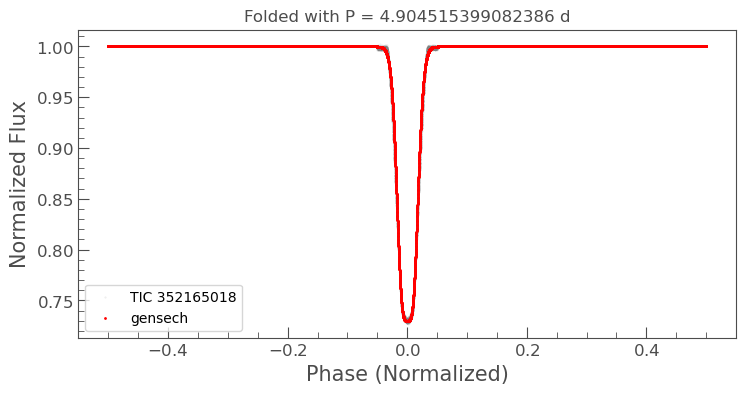

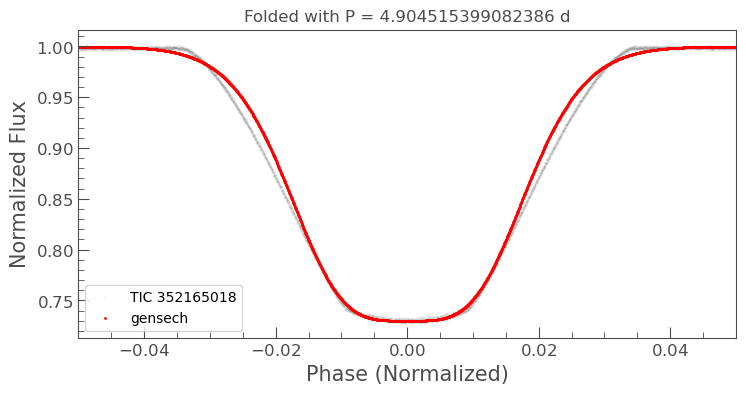

In [87]:
def gensech_model(x, A, B, t0, omega, beta, C, p):
    """
    Calculates the generalized Gaussian model fit for the given parameters.

    Parameters:
    x (float): The input value (time, NOT phase)
    A  (float): The coefficient for the constant term.
    B (float):
    t0 (float): time of minimum / maximum at center(time, NOT phase)
    omega (float):
    beta (float):
    C (float): to account for linear residual
    p (float): the period

    Returns:
    float: The model fit value.
    """
    x_phase = phase_data(x, t0, p)
    t0_phase = phase_data([t0], t0, p)[0]
    exponent = pow((np.abs(x_phase - t0_phase)/omega), beta)
    divisor_term = np.exp(-exponent) + np.exp(exponent)
    model = A - 2 * B / divisor_term  + C * (x_phase - t0_phase)

    return model



# A, B, t0, omega, beta, C, period
# - we use period = 1, t0=0 to make the it like a phased plot,
# - C = 0
start_vals = [1, 0.27, 0, 0.016, 1.9, 0, 1]
y = gensech_model(x, *start_vals)

# # this is the data folded by the coshgauss model above
# ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
# ax.set_title(f"Folded with P = {theta[5]} d");

# this is the data folded by the coshgauss model above
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d");

# overlay it with the model here
ax.scatter(x, y, label="gensech", c="red", alpha=1, s=1);
ax.legend();

# a zoom-in-plot
ax = lc_f_prediction.scatter(s=0.5, c="gray", alpha=0.2);
ax.set_title(f"Folded with P = {theta[5]} d");

# overlay it with the model here
ax.scatter(x, y, label="gensech", c="red", alpha=1, s=1);
ax.legend();
ax.set_xlim(-0.05, 0.05);



# Comparing the parameters of the different models

| Parameter Description                         | coshgauss | gennorm (scipy) | Generalized Gaussian (Kostov+) | Genealized Secant (Kostov+) |
| --------------------------------------------- | --------- | --------------- | ------------------------------ | --------------------------- |
| OOT brightness                                | alpha0    | A               | A                              | A                           |
| dip depth (-ve for coshgauss, +ve for others) | alpha1    | B               | B                              | B                           |
| t0 in phase                                   | t0        | t0              | t0                             | t0                          |
| dip duration primarily                        | d         | scale           | omega                          | omega                       |
| dip shape primarily                           | Tau       | beta            | beta                           | beta                        |
| additional linear term                        | \---      | \---            | C                              | C                           |


- all models have comparable expressiveness
- OOT brightness, dip depth, t0 in phase can all be directly mapped to the lighcurve in question. All models share the same values
- the parameter values that affect dip duration / shape have different values in different models, though conceptually they capture similar characteristics
- The 2 models from Kostov+ have an additional linear term `C (t - t0)` to account for residual linear trend.
  - The linear trend probably refers to the trend in the neighborhood of dips (rather than the whole lightcurve, as a global linear trend does not make sense). The trend could capture the general variation around the time of dips (due to say, pulsation, rotation, etc.)